In [1]:
import pandas as pd
column_names = [
    'Label','Content']
#Orig is the actual dataset given.
temp = pd.read_csv('orig.csv', names = column_names,header=None,chunksize=1000)
df = pd.concat(temp, ignore_index=True)
#df_second = df.iloc[:,1:2]

In [2]:

df['category_id'] = df['Label'].factorize()[0]
category_id_df = df[['Label', 'category_id']].drop_duplicates().sort_values('category_id')
category_to_id = dict(category_id_df.values)
id_to_category = dict(category_id_df[['category_id', 'Label']].values)


In [4]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.externals import joblib

tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5, norm='l2', encoding='latin-1')
features = tfidf.fit_transform(df.Content.astype('str'))

labels = df.category_id
joblib.dump(tfidf,'tfidf.pkl')
joblib.dump(id_to_category, 'dict.pkl')
features.shape

(62204, 89007)

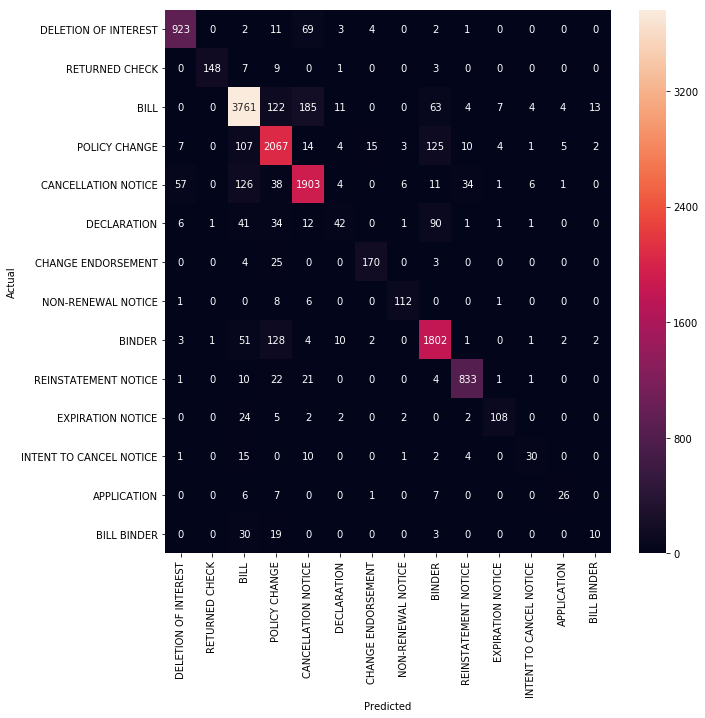

In [6]:
from sklearn.svm import LinearSVC
import matplotlib.pyplot as plt
from sklearn.externals import joblib
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
import seaborn as sns

model = LinearSVC()
X_train, X_test, y_train, y_test, indices_train, indices_test = train_test_split(features, labels, df.index, test_size=0.22, random_state=0)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

conf_mat = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(10,10))

sns.heatmap(conf_mat, annot=True, fmt='d',
            xticklabels=category_id_df.Label.values, yticklabels=category_id_df.Label.values)

joblib.dump(tfidf,'tfidf.pkl')
joblib.dump(model, 'linear_svc_doc_clf_model.pkl')

plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()



In [8]:
from sklearn.model_selection import train_test_split
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score

X_train, X_test, y_train, y_test = train_test_split(df['Content'], df['Label'], random_state = 0)
logistic_reg_model = LogisticRegression()
CV=5
cv_df = pd.DataFrame(index=range(CV))
entries = []
models = [
    LinearSVC(),
    LogisticRegression(random_state=0)]

for model in models:
   model_name = model.__class__.__name__
   accuracies = cross_val_score(model, features, labels, scoring='accuracy', cv=5)
   for fold_idx, accuracy in enumerate(accuracies):
      entries.append((model_name, fold_idx, accuracy))
cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy'])
cv_df.groupby('model_name').accuracy.mean()


model_name
LinearSVC             0.878272
LogisticRegression    0.861874
Name: accuracy, dtype: float64